In [52]:
from fretbursts import *
sns = init_notebook()

In [53]:
full_fname='LS3.h5'
d = loader.photon_hdf5(full_fname)

In [54]:
d.time_max

3600.0531904029799

In [55]:
d.det_t

[array([0, 1, 0, ..., 1, 1, 1], dtype=uint8)]

In [56]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0   14073100
       1   14797436


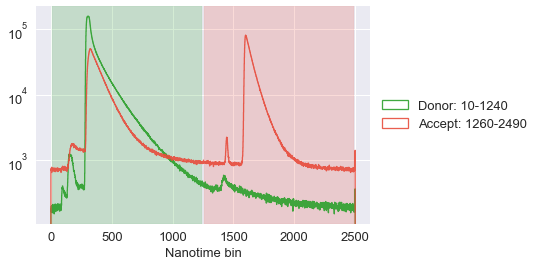

In [57]:
bpl.plot_alternation_hist(d)

In [58]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    28,822,970
#  D  photons in D+A excitation periods:   14,784,567
#  A  photons in D+A excitation periods:   14,038,403
# D+A photons in  D  excitation period:    21,713,037
# D+A photons in  A  excitation period:     7,109,933



In [95]:
d.calc_bg(fun=bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


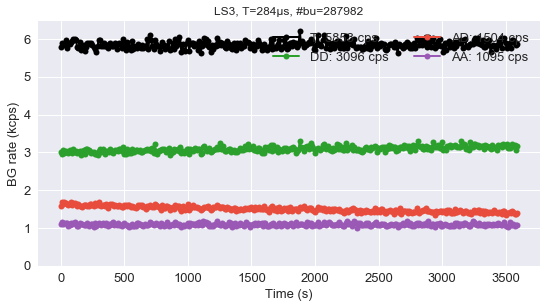

In [96]:
dplot(d, timetrace_bg)

(-50, 50)

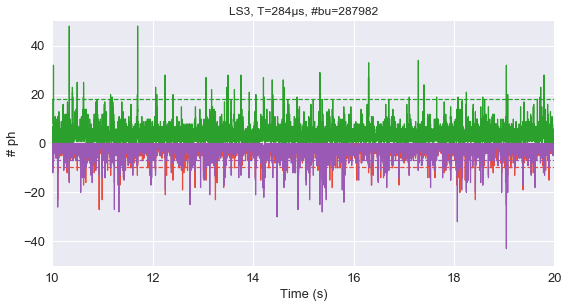

In [92]:
dplot(d, timetrace)
xlim(10, 20)
ylim(-50, 50)

In [62]:
d.burst_search()

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [63]:
ds = d.select_bursts(select_bursts.size, th1=30)

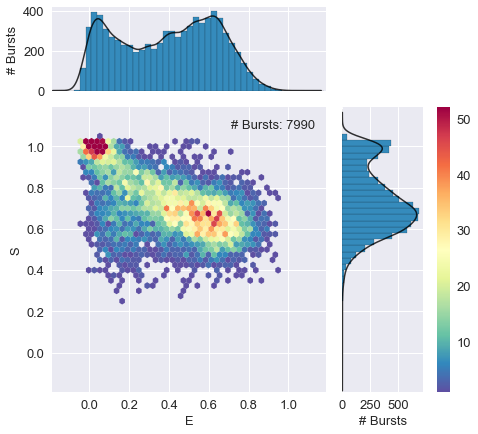

In [64]:
alex_jointplot(ds)

In [65]:
ds.leakage = 0.07

   - Applying background correction.
   - Applying leakage correction.


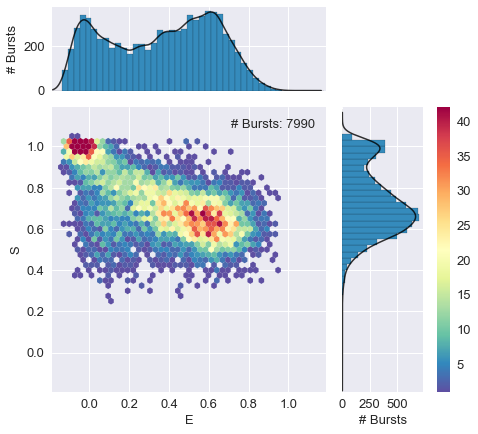

In [66]:
alex_jointplot(ds)

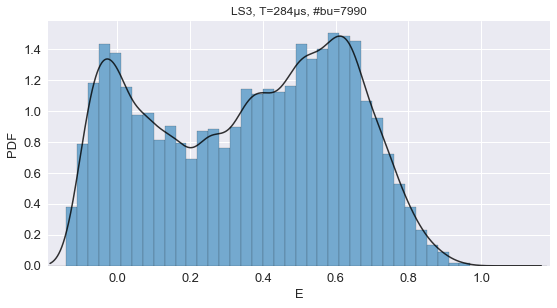

In [67]:
dplot(ds, hist_fret, show_kde=True)

In [68]:
nanotimes = d.nanotimes[0]
nanotimes_d = nanotimes[d.get_D_em()]
nanotimes_a = nanotimes[d.get_A_em()]

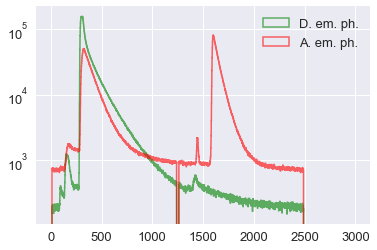

In [69]:
hist_params = dict(bins=range(3000), histtype='step', alpha=0.6, lw=1.5)
#hist(nanotimes, color='k', label='Total ph.', **hist_params)
hist(nanotimes_d, color='g', label='D. em. ph.', **hist_params)
hist(nanotimes_a, color='r', label='A. em. ph.', **hist_params)
plt.legend()
plt.yscale('log')

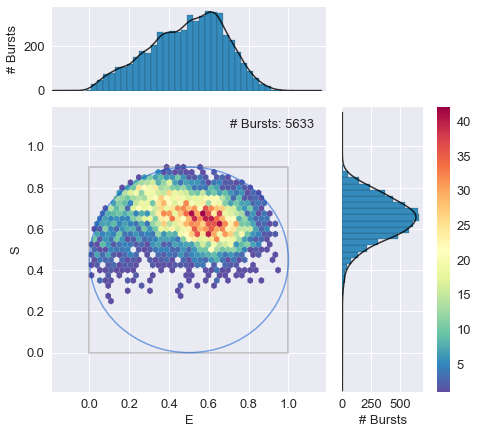

In [101]:
roi = dict(E1=0, E2=1, S1=0.0, S2=0.9, rect=False)
d_fret_mix = ds.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(d_fret_mix)
bpl.plot_ES_selection(g.ax_joint, **roi);

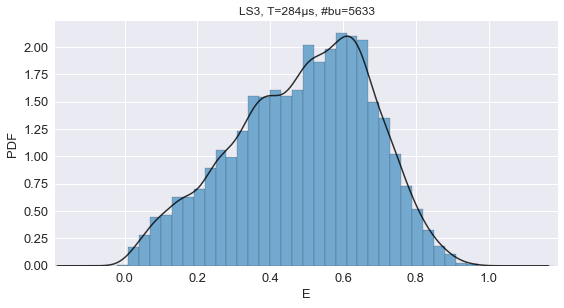

In [102]:
dplot(d_fret_mix, hist_fret, show_kde=True)